In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.dates as mdates
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import gaussian_kde
import itertools
from statsmodels.compat import lzip
from tqdm.notebook import tqdm
import pickle

In [2]:
"""
Define figure parameters for RSE
"""
# image widths (inches from cm) for Elsevier
one_col = 9 / 2.54
half_pg = 14 / 2.54
full_pg = 19 / 2.54

# font sizes
font_xsml = 6
font_sml = 8
font_med = 10
font_lg = 12
font_xlg = 14

# save all figures?
save_all_figs = False

"""
Define input and output files and directories
"""
# output directories
outDIR_figs = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Manucripts/Kearney_et_al_Biomass_from_HLS_VOR/Figures/'
outDIR_tables = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Manucripts/Kearney_et_al_Biomass_from_HLS_VOR/Tables/'
outDIR_figs_R1 = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Manucripts/Kearney_et_al_Biomass_from_HLS_VOR/R1/Figures/'

# variables used in model creation
var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 'nir', 'swir1', 'swir2',
             'bai_126', 'bai_136', 'bai_236', 'bai_246']

# load csv of ground data with extractions
df_full = pd.read_csv('data/bm_extract/TB_all_bm.csv', parse_dates=[1])
df_ext = pd.read_csv('data/bm_extract/TB_all_bm_veg_idxs.csv', parse_dates=[1])
df = pd.merge(df_full, df_ext[['ID', 'Date'] + var_names], how='left', on=['ID', 'Date'])
df['bm'] = df['bm_gm2'].astype('float') * 10.0

# linear model results
suffix = 'strat_projyear_both'
#suffix = 'byproj_both'
log_xfrm = False
project = 'PDOG'
df_results = pd.read_csv("data/bm_modeling/tb_vor_lreg_results_" + suffix + ".csv")
df_results_full = pd.read_csv("data/bm_modeling/tb_vor_lreg_results_" + suffix + "_full.csv")
if suffix.split('_')[0] == 'byproj':
    df_results = df_results[df_results['project'] == project]
    df_results_full = df_results_full[df_results_full['project'] == project]
    #df_results = df_results[df_results['model'] == 'Project']
    #df_results_full = df_results_full[df_results_full['model'] == 'Project']
    
if suffix.split('_')[-1] == 'both':
    df_out_all = df.groupby(['ID', 'Date', 'Project', 'gps_E', 'gps_N']).mean().reset_index()
    df_out_all.loc[df_out_all['bm'] < 1, 'bm'] = 1
else:
    df_out_all = df[df['Method'] == suffix.split('_')[-1]].copy()
    if suffix.split('_')[-1] == 'vor':
        df_out_all.loc[df_out_all['bm'] < 0, 'bm'] = 1
if suffix.split('_')[0] == 'byproj':
    df_out_all = df_out_all[df_out_all['Project'] == project].copy()

In [3]:
#df_out_all = df_out_all[df_out_all['bm'] < 1500]

In [4]:
"""
Define necessary lists and dictionaries
"""

# formatted names for input variables
in_var_dict = {'dfi': 'DFI',
               'ndvi': 'NDVI',
               'ndti': 'NDTI',
               'satvi': 'SATVI',
               'ndii7': 'NDII7',
               'nir': 'NIR',
               'swir1': 'SWIR1',
               'swir2': 'SWIR2',
               'bai_126': 'BAI_126',
               'bai_136': 'BAI_136',
               'bai_236': 'BAI_236',
               'bai_246': 'BAI_246',
               'pct_c3': 'MG-plot',
               'pct_c3_ras': 'MG-map'}

# grouping names for input variables
input_group_dict = {
    'DFI': 'Veg. Indices',
    'NDVI': 'Veg. Indices',
    'NDTI': 'Veg. Indices',
    'SATVI': 'Veg. Indices',
    'NDII7': 'Veg. Indices',
    'NIR': 'Bands',
    'SWIR1': 'Bands',
    'SWIR2': 'Bands',
    'BAI_126': 'BAIs',
    'BAI_136': 'BAIs',
    'BAI_236': 'BAIs',
    'BAI_246': 'BAIs',
    'MG-map': 'Veg. Community'
}

# directory in which to save each model type
mod_dir_dict = {'Temporal': '/Main/',
                'Spatial': '/Supp/'}

In [5]:
"""
Define necessary functions
"""

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', c='black')

Explained variation per principal component: [0.63744866 0.2245978  0.07875583]


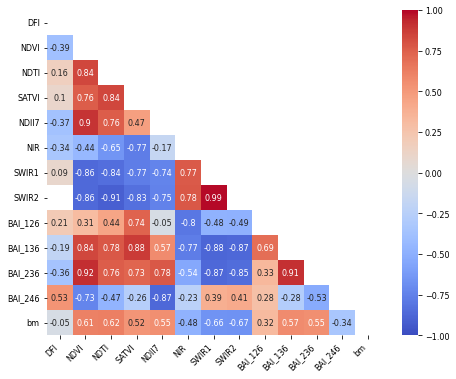

In [6]:
"""
Finish prep of dataset
"""
df_out_all['Year'] = df_out_all['Date'].dt.year
df_out_all = df_out_all[(df_out_all['bm'].notnull()) & (df_out_all[var_names].notnull().any(axis=1))]

from sklearn.preprocessing import StandardScaler
x = df_out_all.loc[:, var_names].values
x = StandardScaler().fit_transform(x) # normalizing the features

from sklearn.decomposition import PCA
pca_vars = PCA(n_components=3)
principalComponents_df = pca_vars.fit_transform(x)

pca_df = pd.DataFrame(data = principalComponents_df,
                      columns = ['PC1', 
                                 'PC2',
                                 'PC3'])
print('Explained variation per principal component: {}'.format(pca_vars.explained_variance_ratio_))

pca_outliers = (pca_df < (pca_df.agg('mean') - pca_df.agg('std')*3)).any(axis=1) | (pca_df > (pca_df.agg('mean') + pca_df.agg('std')*3)).any(axis=1)
df_out_all = df_out_all.reset_index()[~pca_outliers]

"""
Figure (Supplement): Correlation matrix for all input variables
"""
# define variables for correlation matrix
cor_vars_all = df_out_all[var_names + ['bm']]

# create and save correlation matrix
from scipy.stats import pearsonr
corrMatrix = np.round(cor_vars_all.reset_index(drop=True).corr(), 2).rename(index=in_var_dict, columns=in_var_dict)
pvals = pd.DataFrame([[pearsonr(cor_vars_all[c],cor_vars_all[y])[1] for y in cor_vars_all.columns] for c in cor_vars_all.columns],
                     columns=cor_vars_all.columns, index=cor_vars_all.columns)
pvals_mask = pvals > 0.05
mask = np.zeros(corrMatrix.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
mask = pvals_mask.values | mask
fig = plt.figure(figsize=(full_pg, full_pg * 0.8))
ax = sns.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1, center=0, mask=mask, cmap='coolwarm',
                 annot_kws={"size": font_sml})
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=font_sml)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=font_sml)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=font_sml)
if save_all_figs:
    plt.savefig(outDIR_figs_R1 + '/Supp/corrmatrix_inputs.png', dpi=600, bbox_inches='tight', pad_inches=0.2)
#plt.close()

In [7]:
"""
Identify top models based on MAE, % MAE, R^2 and AIC
"""
# identify best models for each metric
df_results_best = pd.DataFrame(
    columns=['model', 'numb_vars', 'min_MAE', 'min_MAE_pct', 'max_R2', 'min_AIC'])
for m in df_results['model'].unique():
    for n in df_results['numb_vars'].unique():
        df_best_tmp = pd.DataFrame({'model': m,
                                    'numb_vars': n,
                                    'min_MAE': df_results['mae_orig_mean'][(df_results['model'] == m) & \
                                                                           (df_results['numb_vars'] == n)].min(),
                                    'min_MAE_pct': df_results['mae_pct_mean'][(df_results['model'] == m) & \
                                                                              (df_results['numb_vars'] == n)].min(),
                                    'max_R2': df_results['R2_adj'][(df_results['model'] == m) & \
                                                               (df_results['numb_vars'] == n)].max(),
                                    'min_AIC': df_results['AIC'][(df_results['model'] == m) & \
                                                                 (df_results['numb_vars'] == n)].min()},
                                   index=[0])
        df_results_best = pd.concat([df_results_best, df_best_tmp])

# identify top n models for each metric
ntop = 10
df_results_tops = pd.DataFrame(columns=df_results.columns)
for m in df_results['model'].unique():
    for n in df_results['numb_vars'].unique():
        df_results_sub_tmp = df_results[(df_results['model'] == m) & \
                                        (df_results['numb_vars'] == n)].sort_values(by='mae_orig_mean',
                                                                              ascending=True)[:ntop]
        df_results_tops = pd.concat([df_results_tops, df_results_sub_tmp])
df_results_feats_best = pd.DataFrame(columns=['model', 'features', 'count', 'oftotal'])
for m in df_results['model'].unique():
    df_results_sub_tmp = df_results[(df_results['model'] == m)].sort_values(by='mae_orig_mean',
                                                                          ascending=True)[:ntop]
    for f in var_names:
        df_results_feats_tmp = pd.DataFrame(dict(model=m,
                                                 features=f,
                                                 count=np.sum([f in n for n in df_results_sub_tmp['formula']]),
                                                 oftotal=ntop),
                                            index=[0])
        df_results_feats_best = pd.concat([df_results_feats_best, df_results_feats_tmp])
    df_results_feats_best['pct'] = df_results_feats_best['count'].astype('float') / df_results_feats_best['oftotal'] \
        .astype('float32')


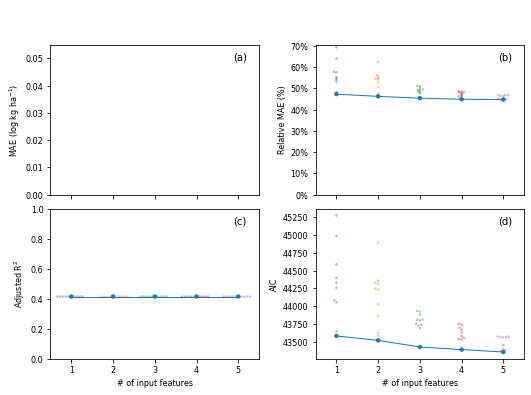

In [8]:
"""
Figure Supplement S3 and S4: Plot model performance of top models using temporal and spatial cross validation
"""
for mod_type in df_results_best.model.unique():
    fig = plt.figure(figsize=(full_pg, half_pg))
    ax1 = fig.add_subplot(2, 2, 1)
    pplot = sns.pointplot(x='numb_vars', y='min_MAE',  data=df_results_best[df_results_best.model == mod_type],
                          alpha=0.5, scale=0.5, ax=ax1)
    plt.setp(pplot.lines, zorder=10, linewidth=1.0)
    plt.setp(pplot.collections, zorder=10, label="")
    vplot = sns.swarmplot(x='numb_vars', y='mae_orig_mean', 
                          data=df_results_tops[df_results_tops.model == mod_type],
                          dodge=False, alpha=0.45, size=2.5, ax=ax1)
    plt.xlabel('')
    plt.ylabel('$\mathregular{MAE\ (log\ kg\ ha^{-1})}$', fontsize=font_sml)
    #ax1.get_legend().remove()
    ax1.set_ylim(bottom=0.0)
    ax1.xaxis.set_major_formatter(mtick.NullFormatter())
    ax1.tick_params(axis='both', which='major', labelsize=font_sml)
    ax1.text(x=0.875, y=0.9, s='(a)', transform=ax1.transAxes, size=font_med)

    ax2 = fig.add_subplot(2, 2, 2)
    pplot2 = sns.pointplot(x='numb_vars', y='min_MAE_pct', 
                           data=df_results_best[df_results_best.model == mod_type],
                           alpha=0.5, scale=0.5, ax=ax2)
    plt.setp(pplot2.lines, zorder=10, linewidth=1.0)
    plt.setp(pplot2.collections, zorder=10, label="")
    vplot2 = sns.swarmplot(x='numb_vars', y='mae_pct_mean', 
                           data=df_results_tops[df_results_tops.model == mod_type],
                           dodge=False, alpha=0.45, size=2.5, ax=ax2)
    plt.xlabel('')
    plt.ylabel('Relative MAE (%)', fontsize=font_sml)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))
    ax2.xaxis.set_major_formatter(mtick.NullFormatter())
    ax2.tick_params(axis='both', which='major', labelsize=font_sml)
    ax2.text(x=0.875, y=0.9, s='(b)', transform=ax2.transAxes, size=font_med)
    #ax2.get_legend().remove()

    ax3 = fig.add_subplot(2, 2, 3)
    pplot3 = sns.pointplot(x='numb_vars', y='max_R2',  data=df_results_best[df_results_best.model == mod_type],
                           alpha=0.5, scale=0.5, ax=ax3)
    plt.setp(pplot3.lines, zorder=10, linewidth=1.0)
    plt.setp(pplot3.collections, zorder=10, label="")
    vplot3 = sns.swarmplot(x='numb_vars', y='R2_adj', 
                           data=df_results_tops[df_results_tops.model == mod_type],
                           dodge=False, alpha=0.45, size=2.5, ax=ax3)
    plt.xlabel('# of input features', fontsize=font_sml)
    plt.ylabel('$\mathregular{Adjusted~R^{2}}$', fontsize=font_sml)
    #ax3.get_legend().remove()
    ax3.set_ylim(bottom=0.0, top=1.0)
    ax3.tick_params(axis='both', which='major', labelsize=font_sml)
    ax3.text(x=0.875, y=0.9, s='(c)', transform=ax3.transAxes, size=font_med)

    ax4 = fig.add_subplot(2, 2, 4)
    pplot4 = sns.pointplot(x='numb_vars', y='min_AIC',  data=df_results_best[df_results_best.model == mod_type],
                           alpha=0.5, scale=0.5, ax=ax4)
    plt.setp(pplot4.lines, zorder=10, linewidth=1.0)
    plt.setp(pplot4.collections, zorder=10, label="")
    vplot4 = sns.swarmplot(x='numb_vars', y='AIC', 
                           data=df_results_tops[df_results_tops.model == mod_type],
                           dodge=False, alpha=0.45, size=2.5, ax=ax4)
    plt.xlabel('# of input features', fontsize=font_sml)
    plt.ylabel('AIC', fontsize=font_sml)
    #ax4.get_legend().remove()
    ax4.tick_params(axis='both', which='major', labelsize=font_sml)
    ax4.text(x=0.875, y=0.9, s='(d)', transform=ax4.transAxes, size=font_med)

    leg2handles, leg2labels = ax2.get_legend_handles_labels()
    for handle in leg2handles:
        handle.set_sizes([10])
    ax2.set_ylim(bottom=0)
    plt.figlegend(leg2handles, [xv_dict[l] for l in leg2labels], fontsize=font_med,
                  loc='upper center', ncol=3, columnspacing=0.5, handletextpad=0.1, frameon=False)

    plt.tight_layout(h_pad=0.5, rect=(0, 0, 1, 0.925))
    if save_all_figs:
        plt.savefig(outDIR_figs_R1 + 'Supp/' + mod_type +
                    '_model_performance_top' + str(ntop) + '.png', dpi=600, bbox_inches='tight', pad_inches=0.2)
    #plt.close()

In [9]:
"""
Calculated weighted relative variable importance for each variable across model types
"""
# set max vars based on where cross-validated metrics stop improving
max_vars = 3

# Calculate decomposed R^2, relative variable importance (RVI) and AIC weights
df_results_feats_ptn = pd.DataFrame(columns=['model', 'kfold', 'features', 'formula', 'RVI', 'weight'])
for m in df_results_full['model'].unique():
    for k in df_results_full['kfold'].unique():
        df_results_sub_tmp = df_results_full[(df_results_full['model'] == m) &
                                             (df_results_full['kfold'] == k) &
                                             (df_results_full['numb_vars'] <= max_vars)].copy()
        aicw_tmp = df_results_sub_tmp['AIC'] \
            .transform(lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))).values
        df_results_sub_tmp.loc[:, 'AICw'] = aicw_tmp
        for f in var_names:
            df_results_sub_f = df_results_sub_tmp[[f in n for n in df_results_sub_tmp['formula']]]
            if len(df_results_sub_f) == 0:
                continue
            else:
                for f_form in df_results_sub_f['formula']:
                    f_form_omitted = re.sub(f + ":[^\+]* \+ ", "",
                                            re.sub(" \+ " + f + ":[^\+]*", "",
                                                   re.sub(" \+ " + f + ":.+?(?= |$)", "",
                                                          re.sub(" \+(?<=\+)[^\+]*:" + f, "",
                                                                 re.sub("\+ " + f + " (?=\+)", "",
                                                                        re.sub("(?<=~ )" + f + " \+ ", "",
                                                                               f_form))))))

                    # print(f_form)
                    # print(f_form_omitted)
                    RVI_tmp = df_results['R2'][(df_results['formula'] == f_form) &
                                               (df_results['model'] == m)].values - \
                              df_results['R2'][(df_results['formula'] == f_form_omitted) & \
                                               (df_results['model'] == m)].values
                    OVI_tmp = df_results['mae_orig_mean'][(df_results['formula'] == f_form) & \
                                                          (df_results['model'] == m)].values - \
                              df_results['mae_orig_mean'][(df_results['formula'] == f_form_omitted) & \
                                                          (df_results['model'] == m)].values
                    weight_tmp = df_results_sub_tmp['AICw'][(df_results_sub_tmp['formula'] == f_form) & \
                                                            (df_results_sub_tmp['model'] == m)].values

                    df_results_feats_tmp = pd.DataFrame(dict(model=m,
                                                             kfold=k,
                                                             features=in_var_dict[f],
                                                             formula=f_form,
                                                             RVI=np.mean(RVI_tmp),
                                                             weight=weight_tmp),
                                                        index=[0])
                    df_results_feats_ptn = pd.concat([df_results_feats_ptn, 
                                                      df_results_feats_tmp])

# calculate weighted relative variable importance (RVIw)
df_results_feats_ptn['RVIw'] = df_results_feats_ptn['RVI'] * df_results_feats_ptn['weight']

# add input variable group field
df_results_feats_ptn['group'] = [input_group_dict[f] for f in df_results_feats_ptn['features']]

# calculate sorted mean RVIw for each feature after summing across each kfold
df_results_feats_grp = df_results_feats_ptn.groupby(['model',
                                                     'kfold',
                                                     'features',
                                                     'group'])['RVIw'].sum().reset_index()
df_results_feats_grp['RVIw_mean'] = df_results_feats_grp.groupby(['model', 'features'])['RVIw'].transform('mean')
df_results_feats_grp = df_results_feats_grp.groupby(['model']) \
    .apply(lambda x: x.sort_values(['RVIw_mean'], ascending=False)).reset_index(drop=True)

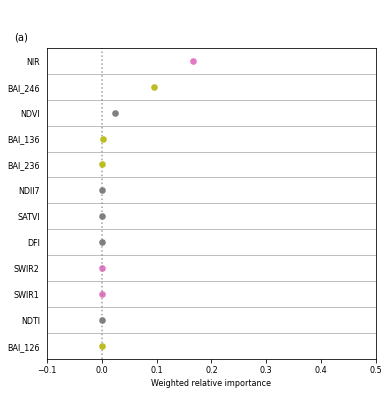

In [10]:
"""
Figure 2: Plot variable importance calculated from all model subsets
"""
for mod_type in df_results_feats_grp['model'].unique():
    fig = plt.figure(figsize=(half_pg, half_pg))
    ax1 = fig.add_subplot(1, 1, 1)
    pplot1 = sns.pointplot(y='features', x='RVIw', hue='group',
                           hue_order=['Bands', 'Veg. Indices', 'BAIs'],
                           orient='h', dodge=False, ax=ax1, linestyles='None', scale=0.75,
                           palette=sns.color_palette()[6:],
                           errwidth=1.0,
                           data=df_results_feats_grp[(df_results_feats_grp['model'] == mod_type)])
    ax1.set_ylabel('')
    ax1.set_xlabel('Weighted relative importance', fontsize=font_sml)
    ax1.get_legend().remove()
    ax1.set_xlim((-0.10, 0.50))
    ax1.set_yticks(np.arange(0.5, len(df_results_feats_grp['features'].unique()) - 1, 1), minor=True)
    ax1.grid(which='minor', axis='y')
    for tic in ax1.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
    for tic in ax1.yaxis.get_minor_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
    ax1.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
    ax1.tick_params(axis='x', which='major', labelsize=font_sml)
    ax1.tick_params(axis='y', which='major', labelsize=font_sml)
    ax1.text(x=-0.1, y=1.025, s='(a)', transform=ax1.transAxes, size=font_med)

    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=font_med,
               columnspacing=0.6, handletextpad=0.1, frameon=False)
    plt.tight_layout(w_pad=3.0, rect=(0, 0, 1, 0.95))
    if save_all_figs:
        plt.savefig(outDIR_figs + mod_dir_dict[mod_type] + mod_type + '_variable_importance.png', dpi=600,
                    bbox_inches='tight', pad_inches=0.2)
    #plt.close()

In [11]:
"""
Create and save tables for top candidate models (at least one AICw > 0.50), sorted by MAE
"""
# calculate AIC weights (AICw) for all models with fewer than max_vars
df_results_full_sub = df_results_full[df_results_full['numb_vars'] <= max_vars].copy()
df_results_full_sub['AICw'] = df_results_full_sub.groupby(['model', 'kfold'])['AIC'] \
    .transform(lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min()))))

# Calculate AIC rank within model group and K-fold, then tally number of times a model is best based on AIC
df_results_full_sub['AIC_rank'] = df_results_full_sub.groupby(['model', 'kfold'])['AIC'].rank()
df_results_full_sub['AIC_tally'] = df_results_full_sub.groupby(['model', 'formula'])['AIC_rank'] \
    .transform(lambda x: np.sum(x[x == 1]))

# Get stats by model
df_results_full_grp = df_results_full_sub.groupby(['model', 'formula']).mean().reset_index()
for col in ['mae_orig', 'mae_kg', 'mae_pct', 'AIC', 'AICw', 'R2', 'pe']:
    df_results_full_grp[col + '_sd'] = df_results_full_sub.groupby(['model', 'formula']).std().reset_index()[col]
for col in ['AICw', 'mae_kg']:
    df_results_full_grp[col + '_max'] = df_results_full_sub.groupby(['model', 'formula']).max().reset_index()[col]

# define fields to include in saved tables
out_features = ['formula',
                'mae_orig', 'mae_orig_sd',
                'mae_kg', 'mae_kg_sd', 'mae_pct', 'mae_pct_sd', 'pe', 'pe_sd',
                'AICw', 'AICw_sd', 'AICw_max', 'R2', 'R2_sd']

# save tables as .csv's, sorted by log-transformed MAE
for mod_type in df_results_full_grp['model'].unique():
    table_tmp = df_results_full_grp.loc[(df_results_full_grp['AICw_max'] >= 0.50) &
                                        (df_results_full_grp['model'] == mod_type),
                                        out_features].sort_values('mae_orig', ascending=True)
    table_tmp['formula'] = table_tmp['formula'].map(
        lambda x: 'Y ~ ' + ' + '.join([in_var_dict[v] for v in re.sub('np\.log\(bm\) ~ ', '', x)
                                      .split(' + ') if v in in_var_dict.keys()]))
    table_tmp['mae_orig'] = table_tmp['mae_orig'].map(lambda x: '{:.4f}'.format(x))
    table_tmp['mae_orig_sd'] = table_tmp['mae_orig_sd'].map(lambda x: '(' + '{:.4f}'.format(x) + ')')
    table_tmp['mae_kg'] = table_tmp['mae_kg'].map(lambda x: '{:.2f}'.format(x))
    table_tmp['mae_kg_sd'] = table_tmp['mae_kg_sd'].map(lambda x: '(' + '{:.2f}'.format(x) + ')')
    table_tmp['mae_pct'] = table_tmp['mae_pct'].map(lambda x: '{:.1%}'.format(x))
    table_tmp['mae_pct_sd'] = table_tmp['mae_pct_sd'].map(lambda x: '(' + '{:.1%}'.format(x) + ')')
    table_tmp['pe'] = table_tmp['pe'].map(lambda x: '{:.1%}'.format(x))
    table_tmp['pe_sd'] = table_tmp['pe_sd'].map(lambda x: '(' + '{:.1%}'.format(x) + ')')
    table_tmp['AICw'] = table_tmp['AICw'].map(lambda x: '{:.2f}'.format(x))
    table_tmp['AICw_sd'] = table_tmp['AICw_sd'].map(lambda x: '(' + '{:.2f}'.format(x) + ')')
    table_tmp['AICw_max'] = table_tmp['AICw_max'].map(lambda x: '{:.2f}'.format(x))
    table_tmp['R2'] = table_tmp['R2'].map(lambda x: '{:.2f}'.format(x))
    table_tmp['R2_sd'] = table_tmp['R2_sd'].map(lambda x: '(' + '{:.2f}'.format(x) + ')')
    if save_all_figs:
        table_tmp.to_excel(outDIR_tables + '/Main/candidate_models_' + xv + '_table_' + mod_type + '_v3.xlsx',
                           index=False)

In [12]:
table_tmp

,formula,mae_orig,mae_orig_sd,mae_kg,mae_kg_sd,mae_pct,mae_pct_sd,pe,pe_sd,AICw,AICw_sd,AICw_max,R2,R2_sd
97,Y ~ NIR + BAI_246,nan,(nan),384.76,(18.26),45.5%,(2.2%),1788.7%,(424.8%),0.91,(0.00),0.91,0.61,(0.00)


In [14]:
# define final models
lr_form_fnl = df_results_full_grp['formula'][97]

# define final model parameters
wtd = False

# save models as objects
if wtd:
    lreg_all = smf.wls(formula=lr_form_fnl,
                            data=df_out_all,
                            weights=1 / df_out_all['bm']).fit()
else:
    lreg_all = smf.ols(formula=lr_form_fnl,
                            data=df_out_all).fit()

In [15]:
#pca_outliers

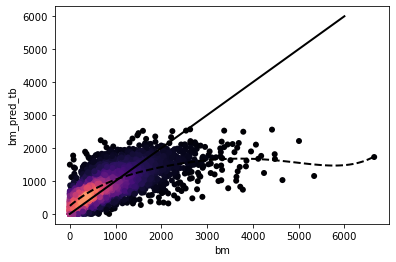

In [17]:
if log_xfrm:
    df_out_all['bm_pred_tb'] = np.exp(lreg_all.predict(df_out_all))
else:
    df_out_all['bm_pred_tb'] = lreg_all.predict(df_out_all)
df_out_all['bm_resid'] = df_out_all['bm_pred_tb'] - df_out_all['bm']
df_out_all.loc[df_out_all['bm_pred_tb'] < 0, 'bm_pred_tb'] = 0
df_out_all= df_out_all[df_out_all['bm_pred_tb'].notnull()]
xy_bm = np.vstack([df_out_all['bm'],
                   df_out_all['bm_pred_tb']])
df_out_all['z_bm_tb'] = gaussian_kde(xy_bm)(xy_bm)
ax = plt.subplot()
sns.scatterplot(x='bm', y='bm_pred_tb', data=df_out_all, hue='z_bm_tb', 
                hue_norm=(1.1e-10, 1.1e-6), palette='magma', edgecolor='none', ax=ax)
sns.regplot(x='bm', y='bm_pred_tb', data=df_out_all, ci=None, marker='', order=5,
           line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2}, ax=ax)
ax.plot([0, 6000], [0, 6000], linewidth=2, c='black', linestyle='solid')
plt.legend().remove()
#plt.xlim(0, 3000)
#plt.ylim(0, 3000)

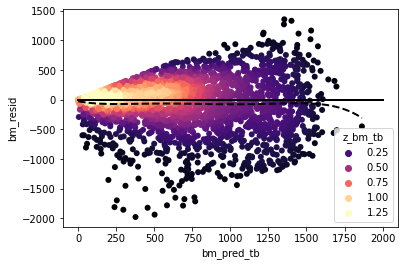

In [16]:
xy_bm = np.vstack([df_out_all['bm_pred_tb'],
                   df_out_all['bm_resid']])
df_out_all['z_bm_tb'] = gaussian_kde(xy_bm)(xy_bm)
ax = plt.subplot()
sns.scatterplot(x='bm_pred_tb', y='bm_resid', data=df_out_all, hue='z_bm_tb', 
                hue_norm=(1.1e-10, 1.1e-6), palette='magma', edgecolor='none', ax=ax)
sns.regplot(x='bm_pred_tb', y='bm_resid', data=df_out_all, ci=None, marker='', order=5,
           line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2}, ax=ax)
ax.plot([0, 2000], [0, 0], linewidth=2, c='black', linestyle='solid')

In [19]:
df_out_all[df_out_all['bm'] > 2500]['bm'].count() / df_out_all['bm'].count()

0.03840631730078966

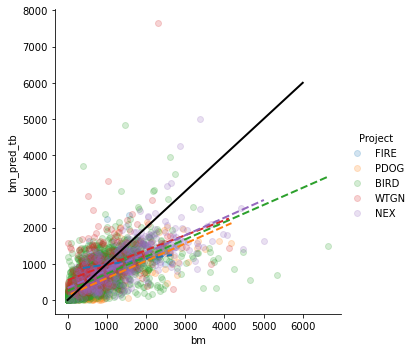

In [ ]:
sns.lmplot(x='bm', y='bm_pred_tb', hue='Project', data=df_out_all, ci=None, order=1,
           line_kws={'linewidth': 2, 'linestyle': 'dashed'},
           scatter_kws={'alpha': 0.2})
plt.plot([0, 6000], [0, 6000], linewidth=2, c='black', linestyle='solid')

In [ ]:
df_out_all[df_out_all['bm_pred_tb'] > 10000]

,index,ID,Date,Project,gps_E,gps_N,Method,bm_gm2,dfi,ndvi,...,swir1,swir2,bai_126,bai_136,bai_236,bai_246,bm,Year,bm_pred_tb,z_bm_tb


<Figure size 432x288 with 0 Axes>

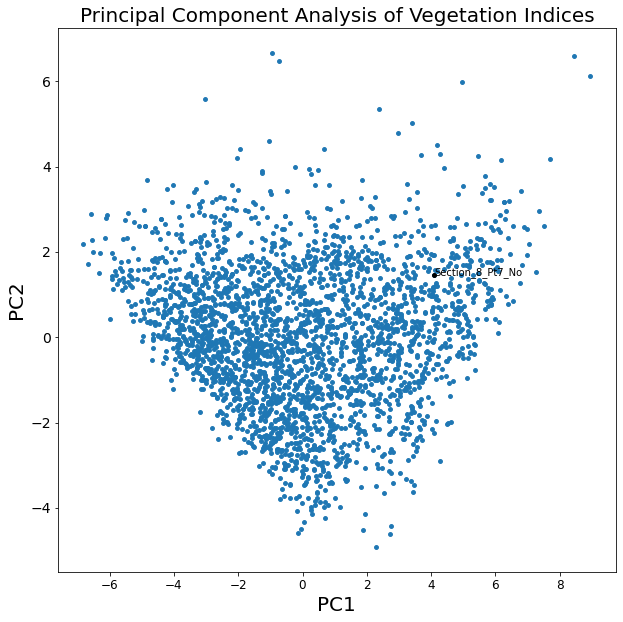

In [35]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
x_is = 'PC1'
y_is = 'PC2'
plt.xlabel(x_is,fontsize=20)
plt.ylabel(y_is,fontsize=20)
plt.title("Principal Component Analysis of Vegetation Indices",fontsize=20)
plt.scatter(pca_df[x_is],
            pca_df[y_is], s = 15)
for i, label in enumerate(df_out_all['ID']):
    if label == 'Section_8_Pt7_No':
        plt.text(pca_df[x_is].iloc[i],
                 pca_df[y_is].iloc[i],
                 label)
        plt.scatter(pca_df[x_is].iloc[i],
                    pca_df[y_is].iloc[i],
                    c='black', s=15)

<AxesSubplot:xlabel='n_years', ylabel='rmae'>

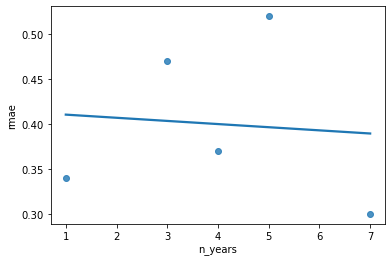

In [17]:
n_years = [7, 4, 5, 3, 1]
rmae = [0.30, 0.37, 0.52, 0.47, 0.34]
df_error = pd.DataFrame(data={'n_years': n_years,
                              'rmae': rmae})
sns.regplot(x='n_years', y='rmae', data=df_error, ci=None)

In [25]:
df_out_all[df_out_all['bm'] < 100].groupby('Project').count()

,index,ID,Date,gps_E,gps_N,bm_gm2,geometry,ndvi,dfi,ndti,...,bai_236,bai_246,bai_346,nir,swir1,swir2,bm,Year,bm_pred_tb,z_bm_tb
Project,,,,,,,,,,,,,,,,,,,,,
BIRD,352,352,352,352,352,352,352,352,352,352,...,352,352,352,352,352,352,352,352,352,352
FIRE,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
NEX,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
PDOG,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
WTGN,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15


In [26]:
df_out_all.groupby('Project').count()

,index,ID,Date,gps_E,gps_N,bm_gm2,geometry,ndvi,dfi,ndti,...,bai_236,bai_246,bai_346,nir,swir1,swir2,bm,Year,bm_pred_tb,z_bm_tb
Project,,,,,,,,,,,,,,,,,,,,,
BIRD,1743,1743,1743,1743,1743,1743,1743,1743,1743,1743,...,1743,1743,1743,1743,1743,1743,1743,1743,1743,1743
FIRE,90,90,90,90,90,90,90,90,90,90,...,90,90,90,90,90,90,90,90,90,90
NEX,351,351,351,351,351,351,351,351,351,351,...,351,351,351,351,351,351,351,351,351,351
PDOG,259,259,259,259,259,259,259,259,259,259,...,259,259,259,259,259,259,259,259,259,259
WTGN,343,343,343,343,343,343,343,343,343,343,...,343,343,343,343,343,343,343,343,343,343
